# Install packages and get the data

* If you do not have the **fastai library** you may install it with `pip install -Uqq fastai`
* If you do not have the **kaggle API** installed and configured:
    * run `pip install kaggle` 
    * verify your phone in the account page https://www.kaggle.com/me/account
    * sign out of kaggle
    * sign back in to kaggle to generate the token from a verified session
    * generate the token from the account page and save it locally see https://github.com/Kaggle/kaggle-api#api-credentials
* To be able to **download the severstal data**, you will currently need to:
    * have a token generated from a session with a verified phone number in kaggle (after verifying your phone sign out and sign back in to kaggle)
    * join the Severstal competition 
    * accept the rules in the competition data download page https://www.kaggle.com/c/severstal-steel-defect-detection/data
    * and only then run `kaggle competitions download -c severstal-steel-defect-detection -p /data/datasets/severstal`

In [1]:
from fastai.vision.all import *
from tqdm.auto import tqdm
from IPython.display import HTML
from pathlib import Path
import zipfile

# Unzip the downloaded data

In [2]:
!ls -l

total 3908
-rw-rw-r-- 1 fireball fireball 975677 Jul 12 15:47 00_data-prep.ipynb
-rw-rw-r-- 1 fireball fireball 915325 Jul  5 11:22 01_eda.ipynb
-rw-rw-r-- 1 fireball fireball 204011 Jun 26 17:44 02_training.ipynb
-rw-rw-r-- 1 fireball fireball 963365 Jun 26 17:44 03_training_ranger.ipynb
-rw-rw-r-- 1 fireball fireball 870764 Jul 12 15:19 04_FullTrainingPipeline.ipynb
-rw-rw-r-- 1 fireball fireball  49533 Jul 12 15:19 05_binary_pretrainer.ipynb
drwxrwxrwx 2 fireball fireball   4096 Jul 12 15:49 data
-rw-rw-r-- 1 fireball fireball    140 Jun 26 17:44 README.md


In [3]:
os.listdir("./data")

['severstal-steel-defect-detection.zip']

In [4]:
path = Path("./data/")
zf_path = path / "severstal-steel-defect-detection.zip"

#path.mkdir(exist_ok=True)
#os.chdir(path)

with zipfile.ZipFile(zf_path, 'r') as zip_ref:
     zip_ref.extractall(path)

path.ls()

(#5) [Path('data/severstal-steel-defect-detection.zip'),Path('data/sample_submission.csv'),Path('data/train_images'),Path('data/train.csv'),Path('data/test_images')]

# Generate the labels file and masks for each train image

Creates a **masks** folder where the data is extracted if one does not exist

In [5]:
def generate_masks():
    (path/"codes.txt").write_text("\n".join(['Background','Divots','Cracks','Scratches','Ablations']))
    masks_path=path / "masks"
    masks_path.mkdir(exist_ok=True)
    mask_files_progress = tqdm(get_image_files(path/'train_images'), position=1, desc=f"Generating train masks: ")
    df = pd.read_csv(path/'train.csv')
    current_file_display = display(display_id=True)
    im_sz = (1600, 256)
    for fn in mask_files_progress:
        current_file_display.update(HTML(f"&nbsp;<small>Saving {path/'masks'/fn.name}...</small>"))
        im = np.zeros(im_sz[0]*im_sz[1], dtype=np.uint8)
        for c in range(1, 5):
            rle_pixels = df[(df["ImageId"]==fn.name) & (df["ClassId"]==c)]["EncodedPixels"].values
            if len(rle_pixels) > 0:
                rle_numbers = [int(numstring) for numstring in rle_pixels[0].split(' ')]
                rle_pairs = np.array(rle_numbers).reshape(-1, 2)
                for index, length in rle_pairs:
                    index -= 1
                    im[index:index+length] = c
        im = Image.fromarray(im.reshape(im_sz).T)
        im.save(f'{masks_path}/{fn.stem}.png')
    current_file_display.update(HTML(f"&nbsp;<small>All done!</small>"))

generate_masks()

Generating train masks:   0%|          | 0/12568 [00:00<?, ?it/s]

# Create the DataLoaders and show a batch

In [6]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"train_images"),
    label_func = lambda o: path/'masks'/f'{o.stem}.png',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

In [9]:
batch = dls.one_batch()
batch[0].shape, batch[1].shape

(torch.Size([8, 3, 256, 1600]), torch.Size([8, 256, 1600]))

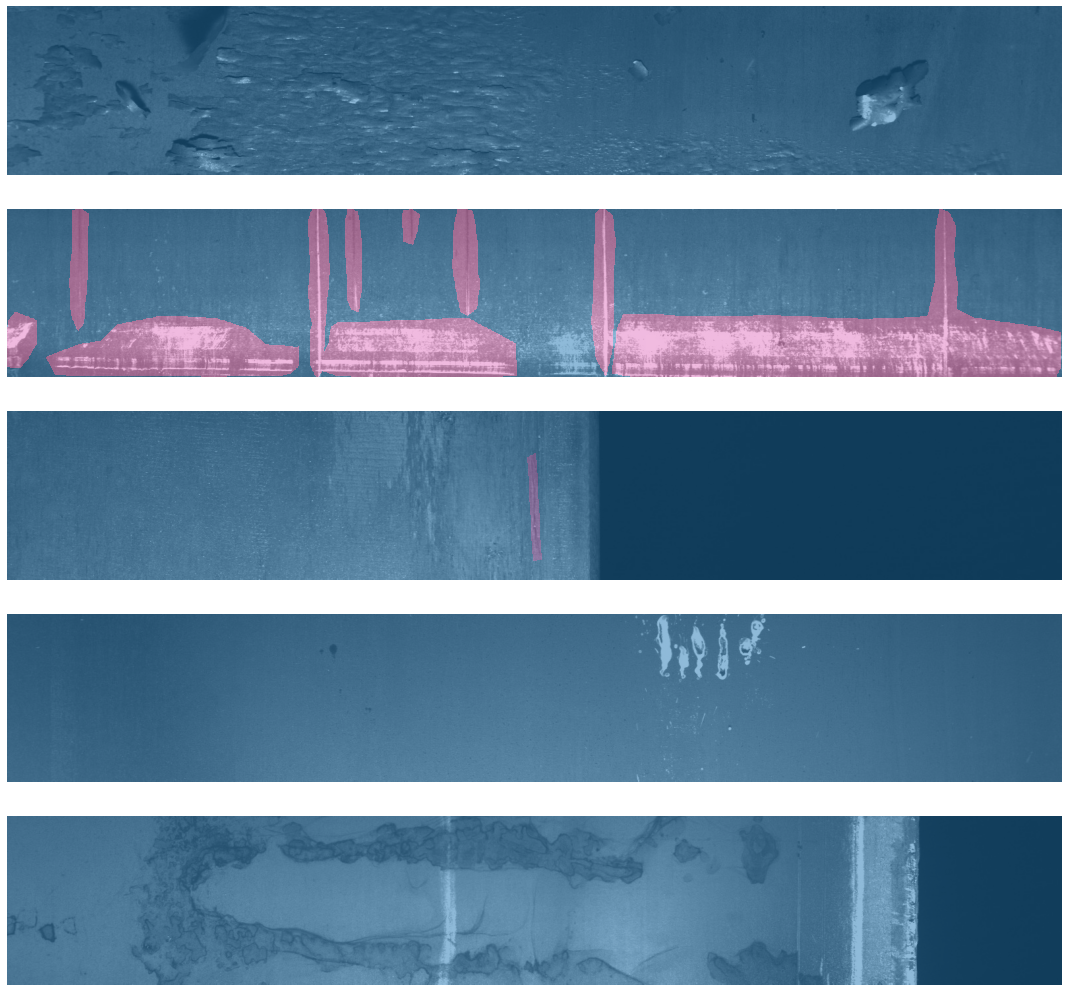

In [7]:
dls.show_batch(max_n=5, nrows=5, figsize=(30,18))